## Censored data (Tobit, Survival functions)

In some applications, we only have access to censored data. A censored variable has a large fraction of observations either at the minimum or maximum and the range of values allowed by the study is not wide enough to capture the variation in the censored variable.

In [3]:
exm <- read.csv("csv/extramarital.csv")
str(exm)

'data.frame':	6366 obs. of  7 variables:
 $ marriage_rating: int  3 3 4 4 5 4 5 5 3 3 ...
 $ age            : num  32 27 22 37 27 27 37 37 22 27 ...
 $ yrs_married    : num  9 13 2.5 16.5 9 9 23 23 2.5 6 ...
 $ religiosity    : int  3 1 1 3 1 2 2 2 2 1 ...
 $ education      : int  17 14 16 16 14 14 12 12 12 16 ...
 $ occupation     : int  2 3 3 5 3 3 5 2 3 3 ...
 $ time_in_affairs: num  0.111 3.231 1.4 0.727 4.667 ...



FALSE  TRUE 
 4313  2053 

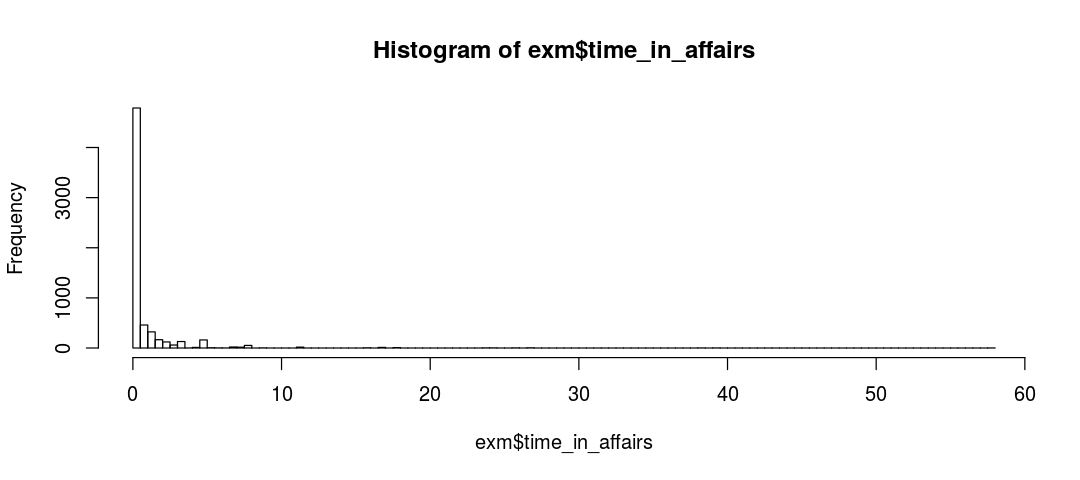

In [29]:
options(repr.plot.width=9, repr.plot.height=4) # resize IRkernel plot size

# numbers of unfaitful partners
table(exm$time_in_affairs > 0)
hist(exm$time_in_affairs, 100)

### Building a Tobit model

In [11]:
set.seed(100)
spl <- sample(nrow(exm), 0.7*nrow(exm))
train <- exm[spl,]
test <- exm[-spl,]

In [13]:
library(survival)
?survreg

In [17]:
# `Surv()` function tells the model that the variable is a censored variable
# even if time_in_affairs cannot be a negative number, we still want to see what effects it would have
# we will compare results with standard linreg later on
model1 <- survreg(Surv(time_in_affairs, time_in_affairs>0, type="left")~., data=train, dist="gaussian")
summary(model1)

# `Scale` refers to the sigma decision variable for maximising the MLE objective function
# Since loglikelihood of model is closer to zero, we can see that the x-vars do affect the y-vars


Call:
survreg(formula = Surv(time_in_affairs, time_in_affairs > 0, 
    type = "left") ~ ., data = train, dist = "gaussian")
                  Value Std. Error      z        p
(Intercept)      7.0440     0.8144   8.65 5.20e-18
marriage_rating -1.4505     0.0847 -17.12 1.11e-65
age             -0.0828     0.0288  -2.88 3.99e-03
yrs_married      0.1043     0.0272   3.83 1.28e-04
religiosity     -0.8853     0.0985  -8.98 2.63e-19
education       -0.1074     0.0428  -2.51 1.21e-02
occupation       0.4027     0.0935   4.31 1.66e-05
Log(scale)       1.4759     0.0206  71.73 0.00e+00

Scale= 4.37 

Gaussian distribution
Loglik(model)= -5436.9   Loglik(intercept only)= -5676.2
	Chisq= 478.62 on 6 degrees of freedom, p= 0 
Number of Newton-Raphson Iterations: 4 
n= 4456 


### Building a linreg model to compare with Tobit

In [18]:
model2 <- lm(time_in_affairs~., data=train)
summary(model2)


Call:
lm(formula = time_in_affairs ~ ., data = train)

Residuals:
   Min     1Q Median     3Q    Max 
-2.436 -0.820 -0.444  0.053 37.518 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.355442   0.302629  11.088  < 2e-16 ***
marriage_rating -0.397490   0.032564 -12.206  < 2e-16 ***
age             -0.009296   0.010619  -0.875  0.38137    
yrs_married     -0.023114   0.010061  -2.297  0.02164 *  
religiosity     -0.223889   0.035981  -6.222 5.35e-10 ***
education       -0.025641   0.015910  -1.612  0.10711    
occupation       0.106046   0.035611   2.978  0.00292 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.066 on 4449 degrees of freedom
Multiple R-squared:  0.05452,	Adjusted R-squared:  0.05325 
F-statistic: 42.76 on 6 and 4449 DF,  p-value: < 2.2e-16


In [23]:
# here, predict tells us `beta*x` and gives us the latent unobservable values
predict1 <- predict(model1, newdata = test)
table(predict1 <= 0, test$time_in_affairs == 0)

predict2 <- predict(model2, newdata = test)
table(predict2 <= 0, test$time_in_affairs == 0)

# we can see how the tobit model is much more accurate in predicting that negative predicted values are seen...
# ... as zeros.

# Tobit model works well with a heavily skewed tail in the histogram of the dataset, that suggests censored data
# It does not work well for all datasets, but only some.

       
        FALSE TRUE
  FALSE    92   43
  TRUE    523 1252

       
        FALSE TRUE
  FALSE   582 1175
  TRUE     33  120

- Since we have $\beta$, $\sigma$ and $x_i$ values already, we can calculate what $P(Y_i | x_i)$ is.
- we can also calculate $E(Y_i | x_i)$

### Survival functions, Duration

In [2]:
heart <- read.csv("csv/heart.csv")
str(heart)

'data.frame':	172 obs. of  7 variables:
 $ start     : num  0 0 0 1 0 36 0 0 0 51 ...
 $ stop      : num  50 6 1 16 36 39 18 3 51 675 ...
 $ event     : int  1 1 0 1 0 1 1 1 0 1 ...
 $ age       : int  31 52 54 54 40 40 21 55 51 51 ...
 $ surgery   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ transplant: int  0 0 0 1 0 1 0 0 0 1 ...
 $ id        : int  1 2 3 3 4 4 5 6 7 7 ...


In [32]:
# There are a total of 103 patients
max(unique(heart$id))

[1] 103

In [38]:
# patient died at day 50 even when he did not have a transplant
subset(heart, id==1)

# patient had a transplant at day 36 and died at day 39
subset(heart, id==4)

# patient had a transplant at day 25, but since data collection stopped at day 1800...
# ...we did not know if the patient survived or died
subset(heart, id==25)

# patient left the programme at day 11
subset(heart, id==102)

start,stop,event,age,surgery,transplant,id
0,50,1,31,0,0,1


,start,stop,event,age,surgery,transplant,id
5,0,36,0,40,0,0,4
6,36,39,1,40,0,1,4


,start,stop,event,age,surgery,transplant,id
39,0,25,0,33,0,0,25
40,25,1800,0,33,0,1,25


,start,stop,event,age,surgery,transplant,id
171,0,11,0,40,0,0,102


### Using Kaplan-Meier estimator

In [47]:
?survfit
?Surv

Call: survfit(formula = Surv(start, stop, event) ~ 1, data = heart)

 time n.risk n.event censored survival std.err lower 95% CI upper 95% CI
    1    103       1        2    0.990 0.00966       0.9715        1.000
    2    102       3        3    0.961 0.01904       0.9246        0.999
    3     99       3        3    0.932 0.02480       0.8847        0.982
    5     96       2        5    0.913 0.02782       0.8597        0.969
    6     94       2        1    0.893 0.03043       0.8355        0.955
    8     92       1        2    0.883 0.03161       0.8237        0.948
    9     91       1        0    0.874 0.03272       0.8119        0.940
   12     89       1        6    0.864 0.03379       0.8002        0.933
   16     88       3        2    0.835 0.03667       0.7656        0.910
   17     85       1        2    0.825 0.03753       0.7543        0.902
   18     84       1        1    0.815 0.03835       0.7431        0.894
   21     83       2        5    0.795 0.03986       0.

,start,stop,event,age,surgery,transplant,id
88,0,10,0,52,0,0,55
112,0,10,0,48,0,0,69


,start,stop,event,age,surgery,transplant,id
171,0,11,0,40,0,0,102


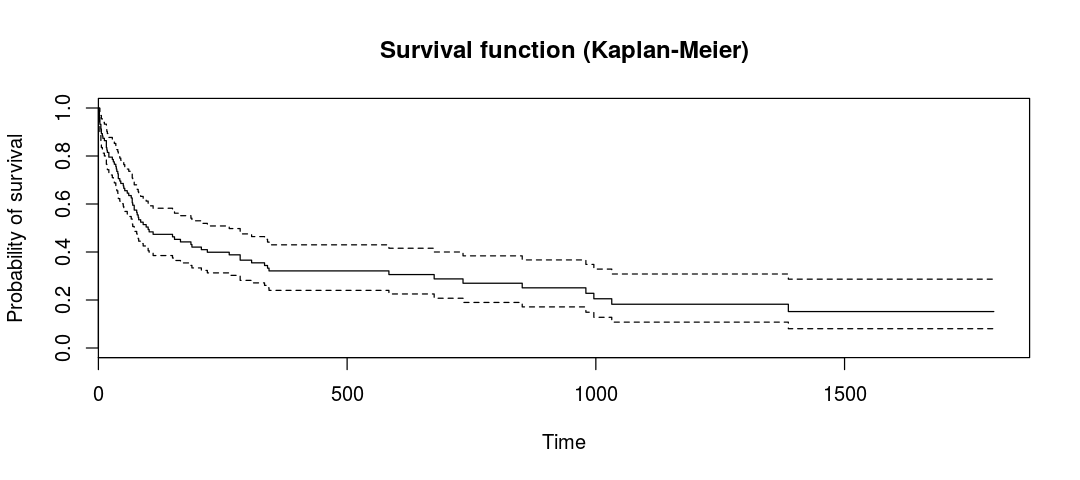

In [12]:
# build a survival function using Kaplan-Meier
library(survival)
km <- survfit(Surv(start, stop, event)~1, data=heart)

# `n.event` merely represents how the curve is
# why the discrepancy between time 9/12? someone probably dropped out of the programme
summary(km)
# find out who died at time=10
subset(heart, stop==10)
# find out who died at time=11
subset(heart, stop==11)

#
options(repr.plot.width=9, repr.plot.height=4) # resize IRkernel plot size
plot(km, main="Survival function (Kaplan-Meier)", xlab="Time", ylab="Probability of survival")

# Q: why do we need KM estimation when we already have a closed-form solution?
# A: The question itself is flawed because we do no know the closed-form equation for the survival...
# ... function a priori and will have to estimate it by collecting data samples. Now, given these data...
# ... samples, we can use the KM estimator to get the approximate survival function given samples.

In [3]:
# find out who died at time=1
subset(heart, stop==1)

,start,stop,event,age,surgery,transplant,id
3,0,1,0,54,0,0,3
22,0,1,1,54,1,0,15
71,0,1,0,36,0,0,45


### Cox proportional hazard model

One drawback of the KM estimator is that it doesnt model the dependence of the x-variables. That is, the rate at which events happen may vary based on time t (hazard rate $\lambda(t) \neq constant$). To account for that, we will need to use the **Cox proportional hazard model**.

$$\large \lambda(t) = \frac{f_{pdf_t}(t)}{s(t)}$$

If we assume that $\lambda(t)$ is of the form $\lambda(t) = \lambda_0 e^{\beta'x}$ and assume only one event can happen at time $t$ (where $x$ are the predictor variables) and let $t_i$ be the time at which individual $i$ exists, then the probability of event occuring is:

$$\large P(event\:i) = \frac{e^{\beta'x_i}}{\sum_{j\in R(t_i)}e^{\beta'x_j}}$$

where $R(t_i)$ is the set of all individuals still existing at time $t_i$. To find $\beta$, we conduct MLE.

Call:
coxph(formula = Surv(start, stop, event) ~ age + surgery + transplant, 
    data = heart)

  n= 172, number of events= 75 

               coef exp(coef) se(coef)      z Pr(>|z|)  
age         0.03026   1.03072  0.01397  2.166   0.0303 *
surgery    -0.77139   0.46237  0.35966 -2.145   0.0320 *
transplant  0.01970   1.01990  0.30823  0.064   0.9490  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
age           1.0307     0.9702    1.0029    1.0593
surgery       0.4624     2.1628    0.2285    0.9357
transplant    1.0199     0.9805    0.5574    1.8661

Concordance= 0.599  (se = 0.037 )
Rsquare= 0.06   (max possible= 0.969 )
Likelihood ratio test= 10.55  on 3 df,   p=0.0144
Wald test            = 9.53  on 3 df,   p=0.02305
Score (logrank) test = 9.85  on 3 df,   p=0.0199


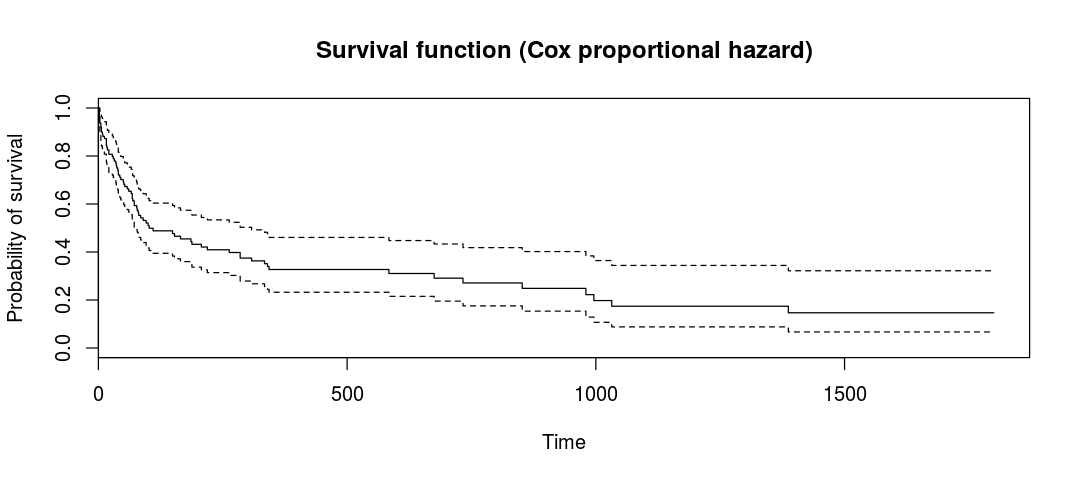

In [13]:
cox <- coxph(Surv(start, stop, event)~age+surgery+transplant, data=heart)
summary(cox)

plot(survfit(cox), main="Survival function (Cox proportional hazard)", xlab="Time", ylab="Probability of survival")